# Segmentation map으로 도로 이미지 만들기
## 1. 이미지 준비하기

In [1]:
import os

# 학습 이미지 리스트 불러오기
train_dir = os.getenv('HOME') + '/aiffel/conditional_generation/data/cityscapes/train/'
print("nums of train images:", len(os.listdir(train_dir)))

nums of train images: 1000


(256, 512, 3)


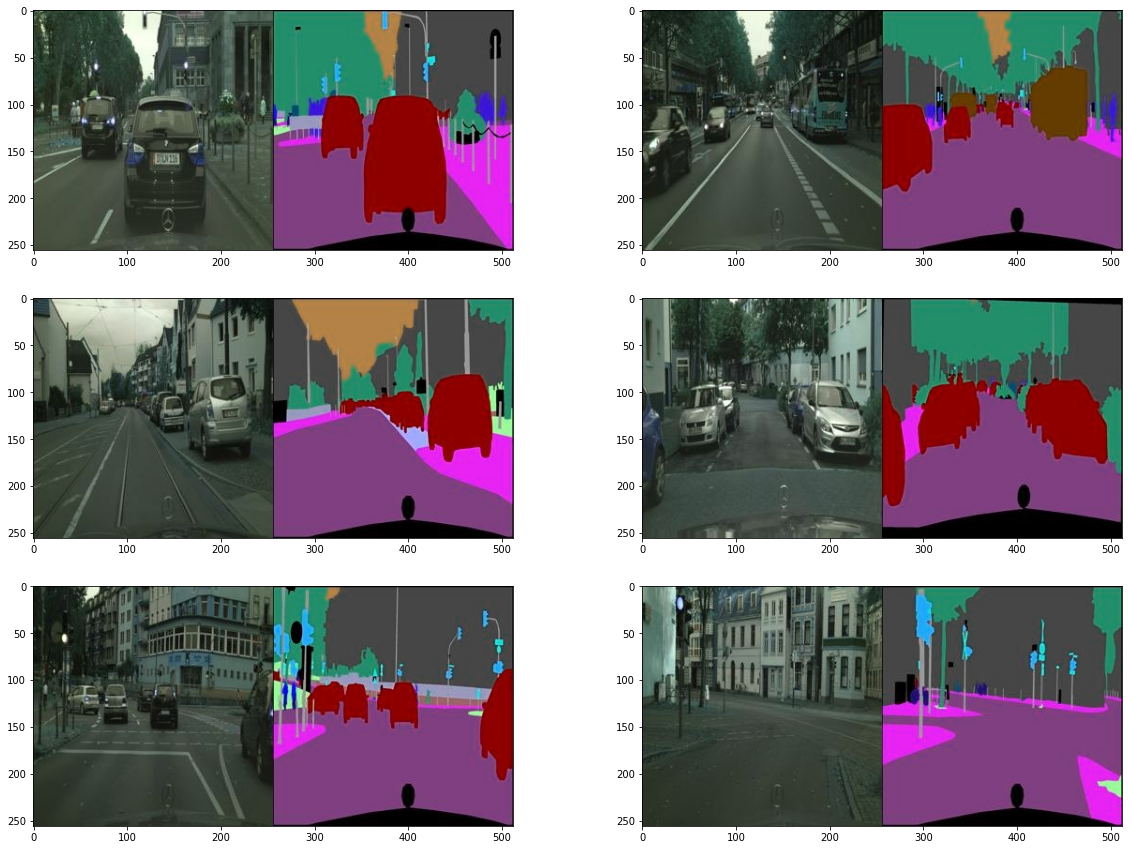

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 학습 이미지 확인하기
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = train_dir + os.listdir(train_dir)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)
    
# 학습 이미지 크기 확인하기
print(img.shape)

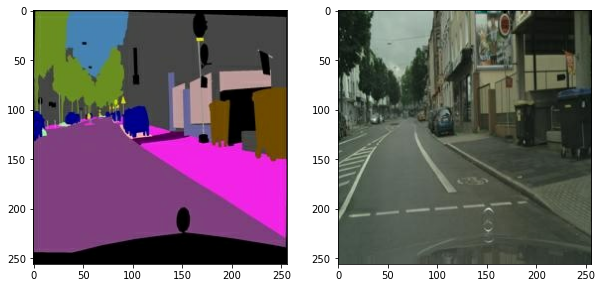

In [3]:
import tensorflow as tf

# 이미지 정규화
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

# 이미지 비정규화
# 결과값 이미지를 다시 0~255 범위의 값으로 바꾸기 위함
def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

# 이미지를 라벨링 이미지와 실제 이미지로 구분
def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, w:, :] 
    sketch = tf.cast(sketch, tf.float32)
    real_imgs = img[:, :w, :] 
    real_imgs = tf.cast(real_imgs, tf.float32)
    return normalize(sketch), normalize(real_imgs)

# 실제로 두 이미지로 분리되는지 확인
f = train_dir + os.listdir(train_dir)[1]
sketch, real_imgs = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(real_imgs))

# 2. Image Augmentation
현재 학습하려는 이미지는 자동차에서 촬영된 도로 이미지와 이를 세그멘테이션한 이미지로 보인다. 이 이미지를 Augmentation을 진행할 때 해당 사진의 특징을 고려해 확대 후 크로핑과 좌우 반전으로만 Augmentation을 진행했다.
- 80% 확률로 2배 확대 후 크로핑
- 50% 확률로 좌우 반전

In [4]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

# Agumentation 함수
@tf.function()
def apply_augmentation(sketch, real_imgs):
    # 두 이미지를 한번에 Agumentation하기 위해 위아래로 겹쳐놓기
    out = tf.concat([sketch, real_imgs], axis=-1)
    
    # 80% 확률로 2배 확대 후 크로핑
    if tf.random.uniform(()) < .8:
        out = image.resize(out, (512, 512), method='nearest')
        out = image.random_crop(out, size=[256, 256, 6])
    
    # 50% 확률로 좌우 반전
    out = image.random_flip_left_right(out)
    
    # 다시 이미지 분리
    return out[...,:3], out[...,3:]

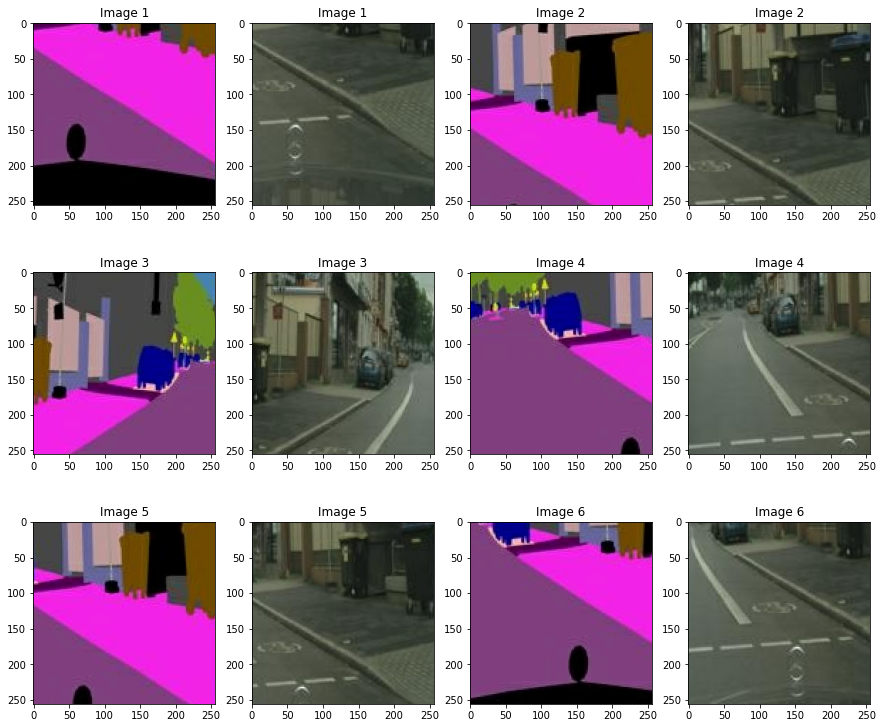

In [5]:
plt.figure(figsize=(15,13))
img_n = 1

# 이미지 Agumentation 확인하기
for i in range(1, 13, 2):
    augmented_sketch, augmented_real_imgs = apply_augmentation(sketch, real_imgs)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_real_imgs)); plt.title(f"Image {img_n}")
    img_n += 1

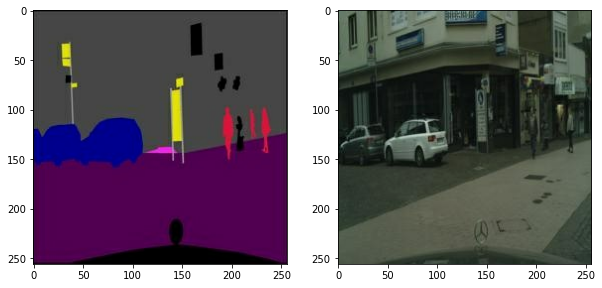

In [6]:
from tensorflow import data

# Agumentation된 학습 이미지 불러오기
def get_train(img_path):
    sketch, real_imgs = load_img(img_path)
    sketch.set_shape((256, 256, 3))
    real_imgs.set_shape((256, 256, 3))
    sketch, real_imgs = apply_augmentation(sketch, real_imgs)
    return sketch, real_imgs

# 모든 학습 이미지 불러오기
train_images = data.Dataset.list_files(train_dir + "*.jpg")
# 학습 데이터를 섞고 minibatch로 나누기
train_images = train_images.map(get_train).shuffle(100).batch(4)

# Agumentation이 제대로 이루어졌는지 확인하기
sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, real_imgs = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(real_imgs[0].astype(np.uint8))

## 3. Generator 선언하기

In [7]:
from tensorflow.keras import layers, Input, Model

# Encoder를 구성하는 레이어
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)


# Decoder를 구성하는 레이어
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [8]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        # Encoder 레이어 별 필터 개수
        encode_filters = [64,128,256,512,512,512,512,512]
        # Decoder 레이어 별 필터 개수
        decode_filters = [512,512,512,512,256,128,64]
        
        # Encoder 레이어 생성
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        # Decoder 레이어 생성
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        # 마지막 출력 레이어
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            # skip connection을 위해 중간 결과물을 저장
            features.append(x)
        
        features = features[:-1] # Encoder의 마지막 결과값은 Decoder에게 직접 전달되니 제외
                    
        for block, feat in zip(self.decode_blocks, features[::-1]): # Encoder 반대 순서로 적용
            x = block(x)
            # Encoder에서 저장해둔 중간 결과물과 결합
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    # Generator의 레이어 정보
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

## 4. Discriminator 선언하기

In [9]:
# Discriminator를 구성하는 레이어 블록 선언
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x

In [10]:
# DicsBlock을 통과한 텐서의 크기 확인해보기
inputs = Input((256,256,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 258, 258, 32)      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 255, 255, 64)      32768     
_________________________________________________________________
batch_normalization (BatchNo (None, 255, 255, 64)      256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 255, 255, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [11]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Discriminator의 레이어 별 필터 개수
        filters = [64,128,256,512,1]
        self.blocks = [layers.Concatenate()]
        for n_filters in filters:
            if n_filters == 64:
                self.blocks.append(DiscBlock(n_filters, use_bn=False))
            elif 1 < n_filters <= 256:
                self.blocks.append(DiscBlock(n_filters))
            elif n_filters == 512:
                self.blocks.append(DiscBlock(n_filters, stride=1))
            else:
                self.blocks.append(DiscBlock(n_filters, stride=1, use_bn=False, act=False))
        
        self.sigmoid = tf.keras.activations.sigmoid
    
    def call(self, x, y):
        out = self.blocks[0]([x, y])
        for block in self.blocks[1:]:
            out = block(out)
        return self.sigmoid(out)
    
    # Discriminator 레이어 정보
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

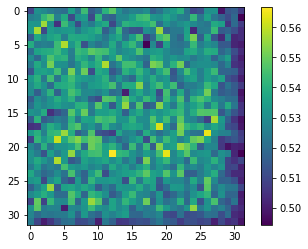

In [12]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## 5. Pix2Pix 모델 학습

In [13]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

# Generator loss 함수
def get_gene_loss(fake_output, real_output, fake_disc):
    # 정규화를 위한 l1 loss, 실제 정답 이미지와 얼마나 유사하게 그려냈는가
    l1_loss = mae(real_output, fake_output)
    # Discriminator가 실제 이미지로 착각했는지의 여부
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

# Discriminator loss 함수
def get_disc_loss(fake_disc, real_disc):
    # 가짜 이미지와 진짜 이미지를 잘 구분해내는가
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [14]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [15]:
@tf.function
def train_step(sketch, real_out):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # 레이블 이미지를 통해 실사 이미지 만들기
        fake_out = generator(sketch)
        # 실제 정답 이미지를 잘 걸러내는지 확인
        real_disc = discriminator(sketch, real_out)
        # 만들어진 실사 이미지를 잘 걸러내는지 확인
        fake_disc = discriminator(sketch, fake_out)
        
        # loss 계산
        gene_loss, l1_loss = get_gene_loss(fake_out, real_out, fake_disc)
        gene_total_loss = gene_loss + 100. * l1_loss # lambda=100 적용
        disc_loss = get_disc_loss(fake_disc, real_disc)
        
        # 그래디언트 계산
        gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
        disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # 그래디언트 적용
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [16]:
EPOCHS = 30

# Pix2Pix 모델
generator = UNetGenerator()
discriminator = Discriminator()

# 반복 학습
for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] "
                  f"Generator_loss:{g_loss.numpy():.4f} "
                  f"L1_loss:{l1_loss.numpy():.4f} "
                  f"Discriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10] Generator_loss:1.1614 L1_loss:0.4714 Discriminator_loss:0.6622

EPOCH[1] - STEP[20] Generator_loss:0.6850 L1_loss:0.2229 Discriminator_loss:1.2839

EPOCH[1] - STEP[30] Generator_loss:0.5757 L1_loss:0.2254 Discriminator_loss:1.4747

EPOCH[1] - STEP[40] Generator_loss:0.7665 L1_loss:0.2562 Discriminator_loss:1.2201

EPOCH[1] - STEP[50] Generator_loss:0.6711 L1_loss:0.2682 Discriminator_loss:1.3176

EPOCH[1] - STEP[60] Generator_loss:0.6981 L1_loss:0.2005 Discriminator_loss:1.2947

EPOCH[1] - STEP[70] Generator_loss:0.7593 L1_loss:0.2723 Discriminator_loss:1.1721

EPOCH[1] - STEP[80] Generator_loss:0.8080 L1_loss:0.2413 Discriminator_loss:1.2650

EPOCH[1] - STEP[90] Generator_loss:0.9378 L1_loss:0.2060 Discriminator_loss:1.2165

EPOCH[1] - STEP[100] Generator_loss:0.7590 L1_loss:0.3081 Discriminator_loss:1.1995

EPOCH[1] - STEP[110] Generator_loss:0.9253 L1_loss:0.2277 Discriminator_loss:1.1350

EPOCH[1] - STEP[120] Generator_loss:0.7315 L1_loss:0.1746 Discriminator_lo

EPOCH[4] - STEP[230] Generator_loss:2.0489 L1_loss:0.1551 Discriminator_loss:1.0509

EPOCH[4] - STEP[240] Generator_loss:1.0867 L1_loss:0.1299 Discriminator_loss:1.1113

EPOCH[4] - STEP[250] Generator_loss:1.3073 L1_loss:0.1754 Discriminator_loss:0.8343

EPOCH[5] - STEP[10] Generator_loss:1.4235 L1_loss:0.1877 Discriminator_loss:0.9198

EPOCH[5] - STEP[20] Generator_loss:0.9089 L1_loss:0.1440 Discriminator_loss:0.9613

EPOCH[5] - STEP[30] Generator_loss:1.3856 L1_loss:0.1214 Discriminator_loss:1.2683

EPOCH[5] - STEP[40] Generator_loss:1.6018 L1_loss:0.1569 Discriminator_loss:0.8886

EPOCH[5] - STEP[50] Generator_loss:1.1365 L1_loss:0.1842 Discriminator_loss:0.9172

EPOCH[5] - STEP[60] Generator_loss:0.3900 L1_loss:0.1382 Discriminator_loss:1.9336

EPOCH[5] - STEP[70] Generator_loss:1.1194 L1_loss:0.1443 Discriminator_loss:1.0878

EPOCH[5] - STEP[80] Generator_loss:0.9147 L1_loss:0.1868 Discriminator_loss:0.9619

EPOCH[5] - STEP[90] Generator_loss:1.6360 L1_loss:0.1490 Discriminator_lo

EPOCH[8] - STEP[200] Generator_loss:1.7573 L1_loss:0.1691 Discriminator_loss:0.5643

EPOCH[8] - STEP[210] Generator_loss:0.8859 L1_loss:0.1551 Discriminator_loss:1.1842

EPOCH[8] - STEP[220] Generator_loss:1.9509 L1_loss:0.1526 Discriminator_loss:1.0929

EPOCH[8] - STEP[230] Generator_loss:1.2312 L1_loss:0.1703 Discriminator_loss:0.9733

EPOCH[8] - STEP[240] Generator_loss:1.1734 L1_loss:0.1556 Discriminator_loss:0.7412

EPOCH[8] - STEP[250] Generator_loss:1.5765 L1_loss:0.2074 Discriminator_loss:0.7835

EPOCH[9] - STEP[10] Generator_loss:1.3435 L1_loss:0.2542 Discriminator_loss:0.5828

EPOCH[9] - STEP[20] Generator_loss:1.8563 L1_loss:0.1965 Discriminator_loss:0.5701

EPOCH[9] - STEP[30] Generator_loss:0.9215 L1_loss:0.1649 Discriminator_loss:1.1432

EPOCH[9] - STEP[40] Generator_loss:0.9291 L1_loss:0.1518 Discriminator_loss:1.2094

EPOCH[9] - STEP[50] Generator_loss:1.2916 L1_loss:0.1684 Discriminator_loss:0.9607

EPOCH[9] - STEP[60] Generator_loss:1.0417 L1_loss:0.0932 Discriminator

EPOCH[12] - STEP[170] Generator_loss:1.2810 L1_loss:0.1289 Discriminator_loss:1.0137

EPOCH[12] - STEP[180] Generator_loss:0.9702 L1_loss:0.2307 Discriminator_loss:1.6761

EPOCH[12] - STEP[190] Generator_loss:1.0529 L1_loss:0.1673 Discriminator_loss:1.0045

EPOCH[12] - STEP[200] Generator_loss:1.3104 L1_loss:0.1918 Discriminator_loss:1.0012

EPOCH[12] - STEP[210] Generator_loss:1.4990 L1_loss:0.1465 Discriminator_loss:1.0230

EPOCH[12] - STEP[220] Generator_loss:1.1079 L1_loss:0.1788 Discriminator_loss:1.1099

EPOCH[12] - STEP[230] Generator_loss:1.5451 L1_loss:0.1892 Discriminator_loss:0.7257

EPOCH[12] - STEP[240] Generator_loss:1.2499 L1_loss:0.1487 Discriminator_loss:0.9418

EPOCH[12] - STEP[250] Generator_loss:1.3327 L1_loss:0.2172 Discriminator_loss:0.7629

EPOCH[13] - STEP[10] Generator_loss:1.6978 L1_loss:0.1179 Discriminator_loss:0.8604

EPOCH[13] - STEP[20] Generator_loss:1.0240 L1_loss:0.1235 Discriminator_loss:1.0103

EPOCH[13] - STEP[30] Generator_loss:1.5890 L1_loss:0.143

EPOCH[16] - STEP[130] Generator_loss:1.5875 L1_loss:0.1590 Discriminator_loss:0.8198

EPOCH[16] - STEP[140] Generator_loss:1.2686 L1_loss:0.1642 Discriminator_loss:0.8686

EPOCH[16] - STEP[150] Generator_loss:0.8148 L1_loss:0.1435 Discriminator_loss:1.2767

EPOCH[16] - STEP[160] Generator_loss:1.0116 L1_loss:0.1894 Discriminator_loss:0.9858

EPOCH[16] - STEP[170] Generator_loss:1.7871 L1_loss:0.1840 Discriminator_loss:0.8325

EPOCH[16] - STEP[180] Generator_loss:1.5902 L1_loss:0.1595 Discriminator_loss:0.8085

EPOCH[16] - STEP[190] Generator_loss:1.5539 L1_loss:0.1498 Discriminator_loss:0.9721

EPOCH[16] - STEP[200] Generator_loss:2.3666 L1_loss:0.1283 Discriminator_loss:1.4088

EPOCH[16] - STEP[210] Generator_loss:1.6408 L1_loss:0.2319 Discriminator_loss:0.7225

EPOCH[16] - STEP[220] Generator_loss:0.9365 L1_loss:0.1505 Discriminator_loss:1.1069

EPOCH[16] - STEP[230] Generator_loss:1.7426 L1_loss:0.2008 Discriminator_loss:0.7713

EPOCH[16] - STEP[240] Generator_loss:1.3026 L1_loss:0.

EPOCH[20] - STEP[90] Generator_loss:1.5543 L1_loss:0.1392 Discriminator_loss:1.0961

EPOCH[20] - STEP[100] Generator_loss:1.5713 L1_loss:0.1624 Discriminator_loss:0.8644

EPOCH[20] - STEP[110] Generator_loss:2.3298 L1_loss:0.1844 Discriminator_loss:0.9261

EPOCH[20] - STEP[120] Generator_loss:1.1464 L1_loss:0.1358 Discriminator_loss:1.6730

EPOCH[20] - STEP[130] Generator_loss:2.2134 L1_loss:0.1579 Discriminator_loss:1.0194

EPOCH[20] - STEP[140] Generator_loss:1.4601 L1_loss:0.1643 Discriminator_loss:0.7112

EPOCH[20] - STEP[150] Generator_loss:1.0445 L1_loss:0.1590 Discriminator_loss:0.8446

EPOCH[20] - STEP[160] Generator_loss:1.6360 L1_loss:0.2088 Discriminator_loss:1.0776

EPOCH[20] - STEP[170] Generator_loss:1.7098 L1_loss:0.1474 Discriminator_loss:0.7854

EPOCH[20] - STEP[180] Generator_loss:1.5356 L1_loss:0.1631 Discriminator_loss:0.6742

EPOCH[20] - STEP[190] Generator_loss:1.8500 L1_loss:0.1774 Discriminator_loss:0.8193

EPOCH[20] - STEP[200] Generator_loss:1.1448 L1_loss:0.2

EPOCH[24] - STEP[50] Generator_loss:1.6940 L1_loss:0.1501 Discriminator_loss:0.7820

EPOCH[24] - STEP[60] Generator_loss:1.3410 L1_loss:0.1400 Discriminator_loss:0.9160

EPOCH[24] - STEP[70] Generator_loss:1.4309 L1_loss:0.1476 Discriminator_loss:0.8740

EPOCH[24] - STEP[80] Generator_loss:0.9742 L1_loss:0.1826 Discriminator_loss:0.9875

EPOCH[24] - STEP[90] Generator_loss:1.0664 L1_loss:0.1551 Discriminator_loss:0.8844

EPOCH[24] - STEP[100] Generator_loss:1.8690 L1_loss:0.1778 Discriminator_loss:0.7334

EPOCH[24] - STEP[110] Generator_loss:1.3891 L1_loss:0.1807 Discriminator_loss:0.7447

EPOCH[24] - STEP[120] Generator_loss:1.6471 L1_loss:0.1478 Discriminator_loss:0.6450

EPOCH[24] - STEP[130] Generator_loss:0.9228 L1_loss:0.1785 Discriminator_loss:1.0221

EPOCH[24] - STEP[140] Generator_loss:1.6272 L1_loss:0.1504 Discriminator_loss:0.7699

EPOCH[24] - STEP[150] Generator_loss:1.3554 L1_loss:0.1780 Discriminator_loss:0.6759

EPOCH[24] - STEP[160] Generator_loss:1.1025 L1_loss:0.1326 

EPOCH[28] - STEP[10] Generator_loss:1.8024 L1_loss:0.1591 Discriminator_loss:0.8239

EPOCH[28] - STEP[20] Generator_loss:1.3362 L1_loss:0.1559 Discriminator_loss:0.7676

EPOCH[28] - STEP[30] Generator_loss:1.5244 L1_loss:0.1645 Discriminator_loss:0.7699

EPOCH[28] - STEP[40] Generator_loss:1.5601 L1_loss:0.1601 Discriminator_loss:0.7070

EPOCH[28] - STEP[50] Generator_loss:1.6895 L1_loss:0.1370 Discriminator_loss:0.8562

EPOCH[28] - STEP[60] Generator_loss:1.7585 L1_loss:0.1215 Discriminator_loss:0.9736

EPOCH[28] - STEP[70] Generator_loss:1.2848 L1_loss:0.1273 Discriminator_loss:0.8532

EPOCH[28] - STEP[80] Generator_loss:1.8226 L1_loss:0.1637 Discriminator_loss:0.4762

EPOCH[28] - STEP[90] Generator_loss:1.4618 L1_loss:0.2158 Discriminator_loss:0.7877

EPOCH[28] - STEP[100] Generator_loss:1.1573 L1_loss:0.1383 Discriminator_loss:1.0139

EPOCH[28] - STEP[110] Generator_loss:1.5868 L1_loss:0.1456 Discriminator_loss:0.8623

EPOCH[28] - STEP[120] Generator_loss:1.5105 L1_loss:0.1812 Disc

## 6. 학습 결과 확인하기

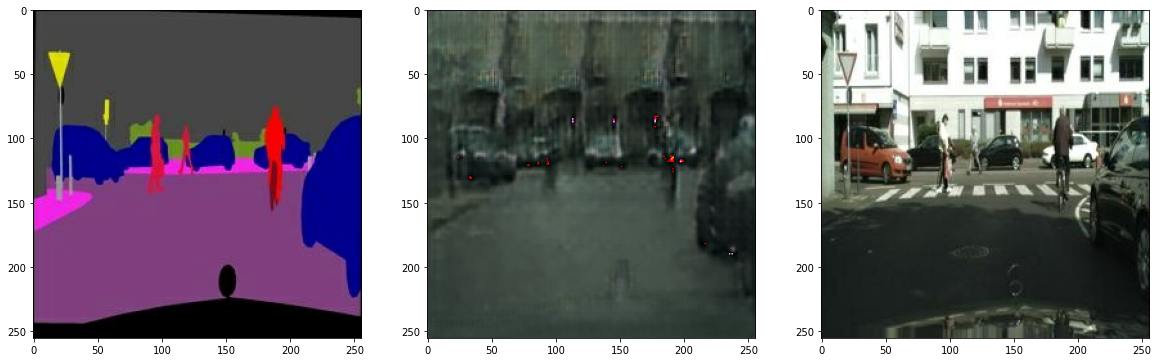

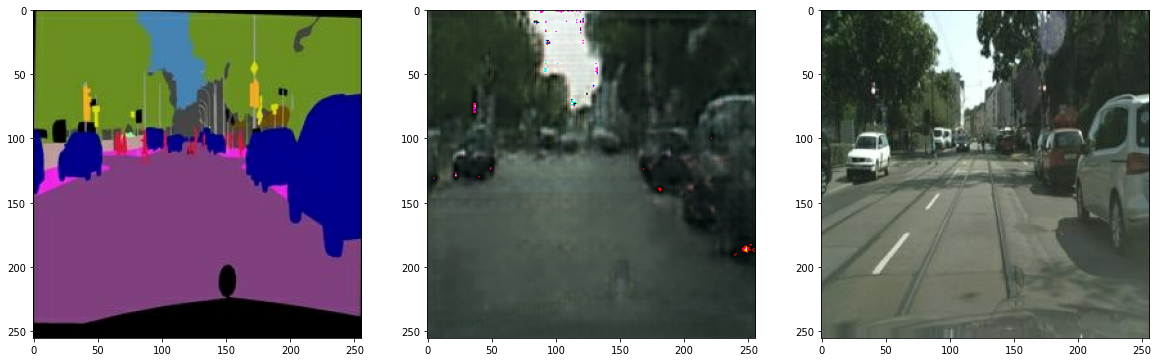

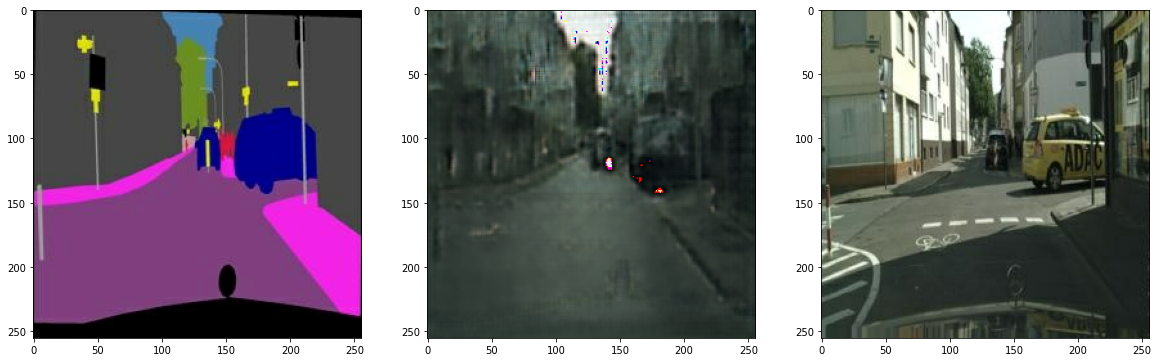

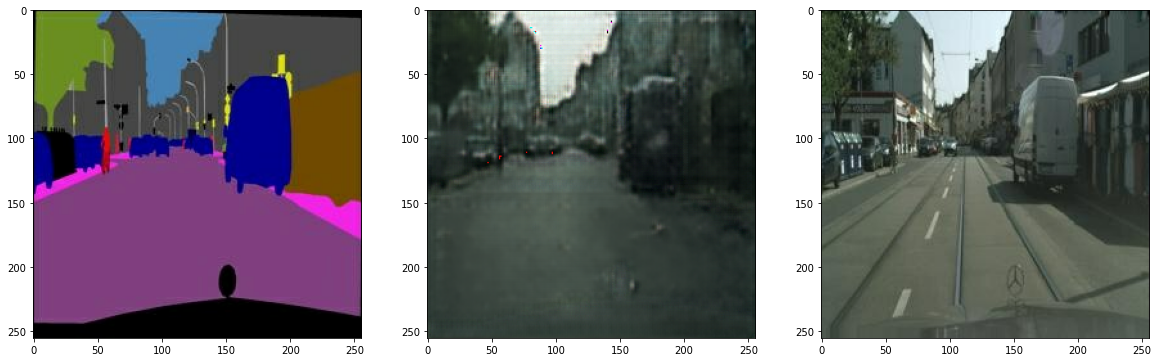

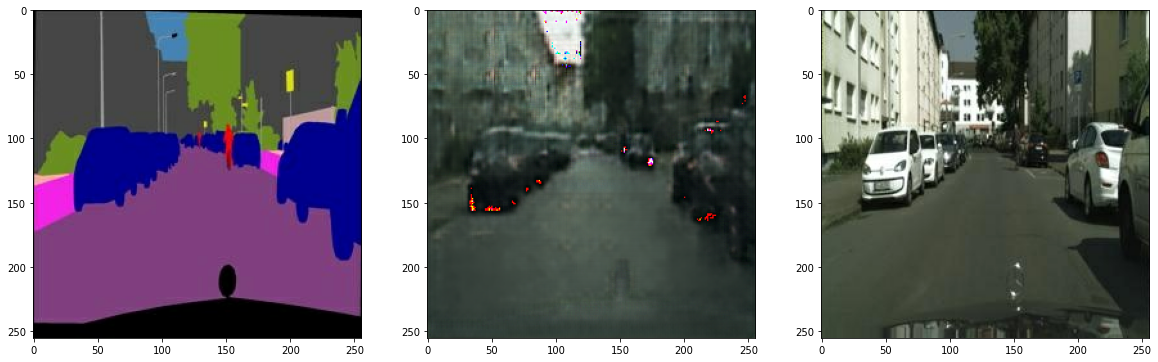

In [17]:
val_dir = train_dir = os.getenv('HOME') + '/aiffel/conditional_generation/data/cityscapes/val/'

# 검증 이미지 리스트
val_img_names = os.listdir(val_dir)

nums_val_imgs = len(val_img_names)

# 검증 이미지로 실사 이미지가 잘 만들어지는지 확인하기
for i, val_img_name in enumerate(val_img_names):
    f = val_dir + val_img_name
    sketch, colored = load_img(f)

    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10* nums_val_imgs))
    # 레이블 이미지
    plt.subplot(nums_val_imgs, 3, i * 3 + 1); plt.imshow(denormalize(sketch))
    # 모델이 생성한 실사 이미지
    plt.subplot(nums_val_imgs, 3, i * 3 + 2); plt.imshow(pred[0])
    # 실제 이미지
    plt.subplot(nums_val_imgs, 3, i * 3 + 3); plt.imshow(denormalize(colored))
plt.show()